# Thrombectomy pilot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from xgboost import XGBClassifier
import seaborn as sns


In [2]:
data = pd.read_csv('./data/complete_ml_data.csv')

In [3]:
X_fields = [
        'prior_disability',
        'stroke_severity',
        'onset_to_thrombolysis',
        'age',
        'precise_onset_known',
        'any_afib_diagnosis',
        'onset_to_thrombectomy']



In [ ]:
# In data where onset_to_thrombolysis is empty set to 99999
data['onset_to_thrombolysis'] = data['onset_to_thrombolysis'].fillna(99999)
data['arrival_to_thrombectomy_time'] = data['arrival_to_thrombectomy_time'].fillna(99999)
# Limit to stroke severity > 10
data = data[data['stroke_severity'] > 5]
# Where arrival to thrombectomy time is present calculate onset to thrombectomy
data['onset_to_thrombectomy'] = data['arrival_to_thrombectomy_time'] + data['onset_to_arrival_time']
# Set max onset to thrombectomy to 99999
data['onset_to_thrombectomy'] = data['onset_to_thrombectomy'].apply(lambda x: min(x, 99999))
# Limit to patients arriving 6 hours after onset
#data = data[data['onset_to_arrival_time'] <= 360]
# Limit is ischaemic stroke only
data = data[data['infarction'] == 1]
# Exclude where thrombectomy time >480 and < 99999 (avoid using late thrombectomy)
data = data[(data['onset_to_thrombectomy'] <= 480) | (data['onset_to_thrombectomy'] == 99999)]


In [6]:
X = data[X_fields]
y = data['discharge_disability'] <= 2

# Split 80:20
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train)


37392

In [7]:
# Fit the model
model = XGBClassifier(verbosity=0, seed=42)
model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [8]:
# Get ROC AUC
from sklearn.metrics import roc_auc_score
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_probs)

0.8428063379607162

In [22]:
# Fit model to whole data
model.fit(X, y)

# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Get feature values and SHAP values for arrival_to_thrombectomy_time
feature = 'onset_to_thrombectomy'
feature_index = X_fields.index(feature)
feature_values = X[feature].values
shap_values_feature = shap_values[:, feature_index]

# Get values after changing onset_to_thrombectomy to 99999
X_modified = X.copy()
X_modified['onset_to_thrombectomy'] = 99999
shap_values_modified = explainer.shap_values(X_modified)
shap_values_modified = shap_values_modified[:, feature_index]
# Calculate difference in SHAP values
thrombectomy_effect = shap_values_feature - shap_values_modified
# Keep only those where thrombectomy time is less than 99999
mask = X['onset_to_thrombectomy'] < 99999
thrombectomy_effect = thrombectomy_effect[mask]
thrombectomy_time = feature_values[mask]

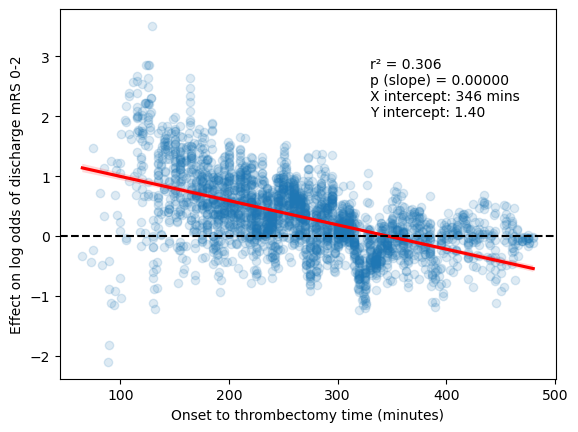

In [26]:
# Plot a seaborn regression plot with confidence limits
sns.regplot(x=thrombectomy_time, y=thrombectomy_effect, ci=95, 
            scatter_kws={'alpha':0.15}, line_kws={'color': 'red'})
plt.xlabel('Onset to thrombectomy time (minutes)')
plt.ylabel('Effect on log odds of discharge mRS 0-2')
# Add aline at y=0
plt.axhline(y=0, color='black', linestyle='--')
# Add p value
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(thrombectomy_time, thrombectomy_effect)

# Get intercepts at x and y axis
x_intercept = -intercept/slope
y_intercept = intercept

# Add r-shared, p value, and inercepts to plot
textstr = f'r² = {r_value**2:.3f}\np (slope) = {p_value:.5f}\nX intercept: {
    x_intercept:.0f} mins\nY intercept: {y_intercept:.2f}'
plt.text(330, 2.0, textstr)

# save the plot
plt.savefig('thrombectomy.png', dpi=300)
plt.show()

In [12]:
mask.sum()

np.int64(2222)